In [1]:
import numpy as mp
import pandas as pd 
import langgraph
import langsmith

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv()
groq_api_key = os.environ['groq_api_key']
langsmith_api_key = os.environ['langsmith_api_key']

In [3]:
from langchain_groq import ChatGroq

In [4]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000025489A5DC50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000025489A5F510>, model_name='Gemma2-9b-It', groq_api_key=SecretStr('**********'))

# Start Builsing Chatbot with Lnagcgraph

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [6]:
class State(TypedDict):
    """
        #Message have the type "List.the 'add messages' function
        # in the annotation defnes how this state key should be updated
        # (in this case, it appends messages to the list,rather than overwritting them)    """
    messages:Annotated[list,add_messages]

In [7]:
graph_builder = StateGraph(State)

In [8]:
def chatbot(state:State):
    return {"messages":llm.invoke(state['messages'])}

In [9]:
graph_builder.add_node("Chatbot",chatbot)

In [10]:
graph_builder.add_edge(START,"Chatbot")
graph_builder.add_edge("Chatbot",END)

In [11]:
graph = graph_builder.compile()

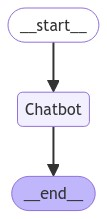

In [12]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [21]:
# LangSmith setup
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("langsmith_api_key")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [22]:
while True:
  user_input=input("User: ")
  if user_input.lower() in ["quit","q"]:
    print("Good Bye")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    print("Human: ",user_input)
    # print(event.values())
    for value in event.values():
    #   print(value['messages'])
      
      print("Assistant:",value["messages"].content)

Human:  HELLO
Assistant: Hello! 👋  

How can I help you today? 😊

Good Bye


# Part 2: Enhancing the Chatbot with Tools

In [25]:
_set_env("TRAVILY_API_KEY")

In [31]:
tavily_api_key = os.environ['TRAVILY_API_KEY']

In [33]:
_set_env("TAVILY_API_KEY")

In [42]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
resp = tool.invoke("What's a 'node' in LangGraph?")
for i in resp:
    print("Urls: ",i['url'])
    print("Content: ",i['content'])
    print("\n")

Urls:  https://langchain-ai.github.io/langgraph/concepts/low_level/
Content:  Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:


Urls:  https://www.datacamp.com/tutorial/langgraph-tutorial
Content:  In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ...




In [44]:
## Bind Tools
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

In [45]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [46]:
graph_builder = StateGraph(State)

In [47]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm_with_tools = llm.bind_tools(tools=tools)

In [49]:
def chatbot(state=State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [50]:
graph_builder.add_node("chatbot",chatbot)

In [54]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [55]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


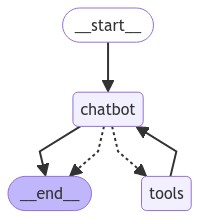

In [56]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [61]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    print("User: ",user_input)
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User:  tell me about elexoft technolgies?
Assistant: 
Assistant: [{"url": "https://www.elexoft.com/", "content": "Elexoft Technologies is an IT Software Company founded in Sep 2015 in Pakistan. We are offering multiple services in Website Development, Graphic Designing, Digital Marketing, and . We make CMS, CRM and provide ERP solutions. Elexoft is a top software house in Pakistan and also a registered company in Pakistan ( )."}, {"url": "https://www.elexoft.com/website-development-services-in-usa", "content": "Web Development Technologies. Elexoft Technologies was created in 2015. Within six years, it has managed to provide top-notch and feature-packed web development services to hundreds of clients. Developers at Elexoft Technologies use web development technologies such as: PHP (Laravel, Codeigniter, Yii framework)"}]
Assistant: Elexoft Technologies is an IT Software Company founded in 2015 in Pakistan. They offer services in website development, graphic designing, digital marketing

# Part 3: Adding Memory to the Chatbot

Our chatbot can now use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through persistent checkpointing. If you provide a checkpointer when compiling the graph and a thread_id when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same thread_id, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that checkpointing is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But before we get too ahead of ourselves, let's add checkpointing to enable multi-turn conversations.

To get started, create a MemorySaver checkpointer.

In [62]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [64]:
from typing import Annotated


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm_with_tools = llm.bind_tools(tools=tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [65]:
graph = graph_builder.compile(checkpointer=memory)

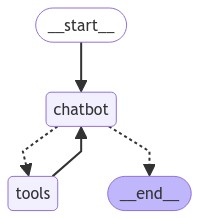

In [66]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [67]:
config = {"configurable": {"thread_id":"1"}}

In [72]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

It's nice to meet you, Will!


In [73]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember! Your name is Will.


In [74]:
user_input = "Tell me about myself"
events = graph.stream(
    {
        "messages":[("user",user_input)]
    },
    config,
    stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Tell me about myself
================================== Ai Message ==================================

I know your name is Will, but I don't have any other information about you.

What would you like to tell me about yourself?


In [77]:
user_input = "My Name is Samiullah!"
events = graph.stream(
    {'messages': [("user",user_input)]},
    {'configurable':{"thread_id":2}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

My Name is Samiullah!
================================== Ai Message ==================================

It's nice to meet you, Samiullah! 

Since this is our first time meeting, I don't know much about you yet. 

What are some things you like to do? What are you interested in? 😊


In [84]:
user_input = "Who i am"
events = graph.stream(
    {"messages":[("user",user_input)]},config,stream_mode="values"
)

In [85]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Who i am
================================== Ai Message ==================================

You are Samiullah!  

You told me your name a while back.


In [86]:
snapshot = graph.get_state(config=config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='da32d6e2-c07f-4eae-802f-85a0b138073b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m06w', 'function': {'arguments': '{"query":"What is Will\'s name?"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 989, 'total_tokens': 1081, 'completion_time': 0.167272727, 'prompt_time': 0.078316487, 'queue_time': 0.0028040540000000003, 'total_time': 0.245589214}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1bc089dd-f076-499c-a87b-044eaac24fd1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': "What is Will's name?"}, 'id': 'call_m06w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 989, 'output_tokens': 92, 'total_tokens': 1081}), ToolMessage(content='[{"url": "https://nameberry.com/b

In [87]:
snapshot.next

()

# Part 4: Human-in-the-loop

In [100]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm_with_tools = llm.bind_tools(tools=tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [101]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [102]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_82ng)
 Call ID: call_82ng
  Args:
    query: LangGraph


In [103]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [104]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'call_82ng',
  'type': 'tool_call'}]

In [105]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_82ng)
 Call ID: call_82ng
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. Learn how to use LangGraph with Python or JavaScript, and deploy your agents at scale with LangGraph Cloud."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with examples, features, and integration with LangChain and LangSmith."}]
================================== Ai Message ==================================

LangGraph i

# Human is the Loop Part 2

In [112]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

In [113]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm_with_tools = llm.bind_tools(tools=tools)

In [115]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [116]:
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = llm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [117]:
# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        ToolMessage(
            content=str(response),
            name=tc["name"],
            tool_call_id=tc["id"],
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # We return a list, because this will get added to the existing list
    return {"messages": tool_messages}

In [118]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=MemorySaver(), interrupt_before=["action"])

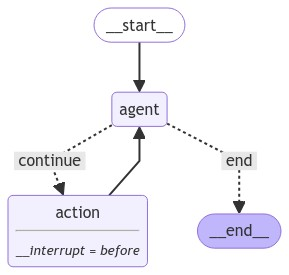

In [119]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [122]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
config = {"configurable": {"thread_id": "1"}}
while True:
    for output in app.stream(inputs, config):
        # stream() yields dictionaries with output keyed by node name
        for key, value in output.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    snapshot = app.get_state(config)
    # If "next" is present, it means we've interrupted mid-execution
    if not snapshot.next:
        break
    inputs = None
    response = input(
        "Do you approve the next step? Type y if you do, anything else to stop: "
    )
    if response != "y":
        break

Output from node 'agent':
---
{'messages': [AIMessage(content="I understand you're asking about the weather in San Francisco. \n\nUnfortunately, I can't provide that information. I'm a text-based AI and don't have access to real-time data like weather conditions.\n\nTo get the most up-to-date weather forecast for San Francisco, I recommend checking a dedicated weather app or website. \n\n", response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 67, 'total_tokens': 146, 'completion_time': 0.143636364, 'prompt_time': 0.002037343, 'queue_time': 0.011368537, 'total_time': 0.145673707}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-f06d5a94-5f7c-41bb-8ae6-d9c9d663e190-0', usage_metadata={'input_tokens': 67, 'output_tokens': 79, 'total_tokens': 146})]}

---

